In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import random as rd

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.util import minibatch, compounding
from nltk.stem.porter import *  

import re
import urllib.request
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

nlp = spacy.load("en_core_web_md")

from spacy import displacy
import df_helper as dfh

from sklearn.utils.random import sample_without_replacement
import importlib
import pickle
from sklearn.feature_selection import SelectKBest, chi2,  RFE, RFECV, SelectFpr

In [2]:
# importlib.reload(dfh)

def download_datafiles():
    url = 'https://datasets.figure-eight.com/figure_eight_datasets/disaster_response_data/disaster_response_messages_training.csv'  
    urllib.request.urlretrieve(url, 'disaster_response_messages_training.csv')
    url = 'https://datasets.figure-eight.com/figure_eight_datasets/disaster_response_data/disaster_response_messages_test.csv'  
    urllib.request.urlretrieve(url, 'disaster_response_messages_test.csv')
    url = 'https://datasets.figure-eight.com/figure_eight_datasets/disaster_response_data/disaster_response_messages_validation.csv'  
    urllib.request.urlretrieve(url, 'disaster_response_messages_validation.csv')

In [3]:
from sklearn.base import TransformerMixin


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.metrics import make_scorer, accuracy_score, f1_score, fbeta_score, classification_report, confusion_matrix

import sklearn.metrics as met
from sklearn.metrics import precision_recall_curve, roc_curve, auc, matthews_corrcoef
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer, average_precision_score, auc, \
    accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report, \
    brier_score_loss, roc_auc_score

from scipy.stats import randint as sp_randint , uniform
import eli5

In [4]:
def transform_sentence(bow, message):
    # for eli5
    
    print("original: ",message)
    
    words=np.array(bow.get_feature_names())
    TR=bow.transform([ message ])
    g,ind=TR.nonzero()
    transformed=",".join(words[ind]) 
    print("transformed: ",transformed)
    print()
    
def explain_message(pos,fn_messages,pipe,dataset,top=10):
    """
    explain_message(pos,X_test[y_fn],pipe,bow1k_bal)
    """
    
    message=fn_messages.loc[pos]
    transform_sentence(pipe.steps[0][1],message)

    print('Predicted class:', pipe.predict([message ])[0] )
    display(eli5.show_prediction(pipe.steps[2][1],   dataset['Xtest'][pos,:] , target_names=[0,1],
                         feature_names= pipe.steps[0][1].get_feature_names(),top=top) )
    
    
def spacy_tokenizer_stemmer(message):
    message=re.sub("[1-9#@$'!*+%\".()!,]?;",'',message).replace('','').replace('-','')
    message=' '.join(message.split())
    doc=nlp(message)
    words=[]

    stemmer = PorterStemmer()  
    
    remove_ent=[]
    for ent in doc.ents:
        if ent.label_ in ['GPE','LOC','NORP','FAC','ORG','LANGUAGE']:
            remove_ent.append(ent.text)

    # remove punctuation etc
    for token in doc:
        if ( (~token.is_stop)   & (token.pos_!='NUM') & (token.pos_!='PUNCT') & (token.pos_!='SYM') &
           ~(token.text in (remove_ent)) & (len(token.text)>1) ):
            words.append( stemmer.stem(token.text) )
    return(words)

In [5]:


def imbalanced_undersample(X_train,Y_train,n_false_sample, classes=[False,True]):
    """
    resamples the false class classes[0] with n_false_sample to correct for imbalanced data
    
    """
    
    n_false=Y_train.loc[Y_train==classes[0]].shape[0]
    n_true=Y_train.loc[Y_train==classes[1]].shape[0]
    ind_false=Y_train.loc[Y_train==classes[0]].index
    ind_true=Y_train.loc[Y_train==classes[1]].index

    print('Original n_true, n_false:' ,n_true,n_false)
    
    ind_s=sample_without_replacement(n_false,n_false_sample)
    ind=np.hstack((ind_true,ind_false[ind_s]))
    np.random.shuffle(ind)

    X_train2=X_train.iloc[ind].copy()
    Y_train2=Y_train.iloc[ind].copy()
    
    n_false2=Y_train2.loc[Y_train==classes[0]].shape[0]
    n_true2=Y_train2.loc[Y_train==classes[1]].shape[0]
    
    print('Resampled n_true, n_false:' ,n_true2,n_false2)
    
    return(X_train2,Y_train2)

In [6]:
def train_bow(X_train,Y_train, X_test,Y_test,n_false_sample ,  max_df=0.9,min_df=1, max_features=2000 ):
    """
    transforms the training and test set with a reduced B.O.W. with only n_false_sample 
    usage:
    
    bow1k_bal, bow_bal, tfidf = train_bow(X_train,Y_train, X_test,Y_test,n_false_sample ,  max_df=0.9,min_df=1, max_features=2000 )
    """
    
    
    X_train2,Y_train2=imbalanced_undersample(X_train,Y_train,n_false_sample, classes=[False,True])

    bow_bal=CountVectorizer(tokenizer = spacy_tokenizer_stemmer, max_df=max_df,min_df=min_df, max_features=max_features)
    tfidf=TfidfTransformer()     

    bow_bal.fit(X_train2)
    Xbow_train=bow_bal.transform(X_train)
    X_train_tdidf2 = tfidf.fit_transform(Xbow_train)

    Xbow_test = bow_bal.transform(X_test)
    X_test_tdidf2 = tfidf.transform(Xbow_test)
    
    bow1k_bal={'Xtrain':X_train_tdidf2, 'Ytrain':Y_train, 'Xtest':X_test_tdidf2, 'Ytest':Y_test}
    return( bow1k_bal, bow_bal, tfidf )
    

In [7]:
def clf_estimate(cl_dict,bow1k_bal,DOE):
    """
    cl_dict= {label:clf}

    """
    
    c=0
    for  label,clf in cl_dict.items():
        print(label)
        
        clf.fit(bow1k_bal['Xtrain'], bow1k_bal['Ytrain'])
        y_score = clf.predict_proba(bow1k_bal['Xtest'] )[:,1]
        y_pred = clf.predict(bow1k_bal['Xtest'])
        Y_test=bow1k_bal['Ytest']

        if c==0:
            rf=dfh.add_metrics(Y_test,y_score,y_pred,label)
        else:
            rf=dfh.add_metrics(Y_test,y_score,y_pred,label,df=rf)        
            
        c+=1
        
    return(rf)

In [29]:
def make_doe(DOE,bow1k_bal):
    cl_dict=dict()

    for N_est in [10, 20, 50, 100, 200, 500, 1000]:
        cl_dict['RF%d' % N_est]=RandomForestClassifier(  criterion="entropy",class_weight="balanced", n_estimators=N_est)

    N_est=200


    for max_features in [50,100,200,300,500, 1000, 1500, 2000]:
        cl_dict['RF%d_mf%d' % (N_est,max_features) ]=RandomForestClassifier(  criterion="entropy",class_weight="balanced",
                                                                            n_estimators=N_est,max_features=max_features)

    max_features=1500    
    for max_depth in [4,8, 12, 16, 20, 25, 30, 40]:
        cl_dict['RF%d_mf%d_md%d' % (N_est,max_features,max_depth) ]=RandomForestClassifier(  criterion="entropy",class_weight="balanced",
                                                                            n_estimators=N_est,max_features=max_features, max_depth=max_depth)

    for C in [1e-4,1e-3,1e-2,1e-1,0.2,0.5,0.75,1.]:
        cl_dict['LR_C%g' % C]=LogisticRegression(random_state=0, solver='liblinear',penalty='l1',max_iter=200,class_weight='balanced', C=C )
    
    rf=clf_estimate(cl_dict,bow1k_bal,DOE)
    
    rf.to_pickle('DOE_%s.p' % DOE)

In [ ]:
def make_bow_doe():
    df=pd.read_csv('disaster_response_messages_training.csv')
    df=df[['message','food']]

    test_df=pd.read_csv('disaster_response_messages_test.csv')
    test_df=test_df[['message','food']]

    valid_df=pd.read_csv('disaster_response_messages_validation.csv')
    valid_df=valid_df[['message','food']]


    X_train=df['message']
    Y_train=df['food']

    X_test=test_df['message']
    Y_test=test_df['food']

    X_valid=valid_df['message']
    Y_valid=valid_df['food']
    
    n_false_sample= 1000
    n_features=2000

    DOE='false_%s_nwords_%s_mindf_1' % (n_false_sample,n_features)
    print(DOE)

    bow1k_bal, bow_bal, tfidf = train_bow(X_train,Y_train, X_test,Y_test,n_false_sample ,  max_df=0.9,min_df=1, max_features=n_features )
    make_doe(DOE,bow1k_bal)

    n_false_sample= 500
    n_features=2000

    DOE='false_%s_nwords_%s_mindf_1' % (n_false_sample,n_features)
    print(DOE)

    bow1k_bal, bow_bal, tfidf = train_bow(X_train,Y_train, X_test,Y_test,n_false_sample ,  max_df=0.9,min_df=1, max_features=n_features )
    make_doe(DOE,bow1k_bal)

    n_false_sample= 500
    n_features=1000

    DOE='false_%s_nwords_%s_mindf_1' % (n_false_sample,n_features)
    print(DOE)

    bow1k_bal, bow_bal, tfidf = train_bow(X_train,Y_train, X_test,Y_test,n_false_sample ,  max_df=0.9,min_df=1, max_features=n_features )
    make_doe(DOE,bow1k_bal)

    n_false_sample= 500
    n_features=500

    DOE='false_%s_nwords_%s_mindf_1' % (n_false_sample,n_features)
    print(DOE)

    bow1k_bal, bow_bal, tfidf = train_bow(X_train,Y_train, X_test,Y_test,n_false_sample ,  max_df=0.9,min_df=1, max_features=n_features )
    make_doe(DOE,bow1k_bal)

    n_false_sample= 0
    n_features=500

    DOE='false_%s_nwords_%s_mindf_1' % (n_false_sample,n_features)
    print(DOE)

    bow1k_bal, bow_bal, tfidf = train_bow(X_train,Y_train, X_test,Y_test,n_false_sample ,  max_df=0.9,min_df=1, max_features=n_features )
    make_doe(DOE,bow1k_bal)

In [9]:
def load_data():
    """
    usage:
    
    X_train,Y_train,X_test, Y_test,X_valid, Y_valid= load_data()
    
    """

    df=pd.read_csv('disaster_response_messages_training.csv')
    df=df[['message','food']]

    test_df=pd.read_csv('disaster_response_messages_test.csv')
    test_df=test_df[['message','food']]

    valid_df=pd.read_csv('disaster_response_messages_validation.csv')
    valid_df=valid_df[['message','food']]


    X_train=df['message']
    Y_train=df['food']

    X_test=test_df['message']
    Y_test=test_df['food']

    X_valid=valid_df['message']
    Y_valid=valid_df['food']
    return(X_train,Y_train,X_test, Y_test,X_valid, Y_valid )

In [10]:
X_train,Y_train,X_test, Y_test,X_valid, Y_valid= load_data()

C:\anaconda3\envs\ds\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [11]:
n_false_sample= 0
n_features=5000

DOE='false_%s_nwords_%s_mindf_1' % (n_false_sample,n_features)
print(DOE)

bow1k_bal, bow_bal, tfidf = train_bow(X_train,Y_train, X_test,Y_test,n_false_sample ,  max_df=0.9,min_df=1, max_features=n_features )
# make_doe(DOE,bow1k_bal)

with open('%s_data.pkl' % DOE, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(bow1k_bal, f)
print('Saved')

false_0_nwords_5000_mindf_1
Original n_true, n_false: 2329 18717
Resampled n_true, n_false: 2329 0


In [44]:
# make_bow_doe()

In [13]:
def dict_clf_estimate(cl_dict,data_set):
    """
    loops over dictionary of classifiers / pipelines
    
    data_set: data_set['Xtrain'] data_set['Ytrain'] data_set['Xtest'] data_set['Ytest']
    cl_dict= {label:clf}
    
    returns df add_metrics

    """
    
    c=0
    for  label,clf in cl_dict.items():
        print(label)
        
        clf.fit(data_set['Xtrain'], data_set['Ytrain'])
        y_score = clf.predict_proba(data_set['Xtest'] )[:,1]
        y_pred = clf.predict(data_set['Xtest'])
        Y_test=data_set['Ytest']

        if c==0:
            rf=dfh.add_metrics(Y_test,y_score,y_pred,label)
        else:
            rf=dfh.add_metrics(Y_test,y_score,y_pred,label,df=rf)        
            
        c+=1
        
    return(rf)



In [14]:
N_est=50
k=100

clf=Pipeline([
    ('fs', SelectKBest(chi2, k=k) ),
    ('rf',RandomForestClassifier(  criterion="entropy",class_weight="balanced", n_estimators=N_est))    
])




In [15]:
clf.fit(bow1k_bal['Xtrain'], bow1k_bal['Ytrain'])
y_score = clf.predict_proba(bow1k_bal['Xtest'] )[:,1]
y_pred = clf.predict(bow1k_bal['Xtest'])
Y_test=bow1k_bal['Ytest']

# rf=dfh.add_metrics(Y_test,y_score,y_pred,'LR_bal')


In [16]:


print("accuracy_score: ",accuracy_score(Y_test,y_pred))
print("average precision: ",average_precision_score(Y_test,y_score))

print("balanced_accuracy_score: ",balanced_accuracy_score(Y_test,y_pred))
print("ROC AUC: ",roc_auc_score(Y_test,y_score))
print()
print(classification_report(Y_test,y_pred))

dfh.print_cm(Y_test, y_pred)

accuracy_score:  0.9513122860403195
average precision:  0.8332059338586502
balanced_accuracy_score:  0.8471299105727659
ROC AUC:  0.9378504697793488

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2303
           1       0.88      0.71      0.78       326

    accuracy                           0.95      2629
   macro avg       0.92      0.85      0.88      2629
weighted avg       0.95      0.95      0.95      2629

Confusion Matrix
C true,predicted

[[2270   33]
 [  95  231]]

true negatives  : true 0, predicted 0:  2270
false positives : true 0, predicted 1:  33
false negatives : true 1, predicted 0:  95
true positives  : true 1, predicted 1:  231


In [17]:
N_est=50
k=40

clf=Pipeline([
    ('fs', SelectKBest(chi2, k=k) ),
    ('rf',RandomForestClassifier(  criterion="entropy",class_weight="balanced", n_estimators=N_est))    
])

clf.fit(bow1k_bal['Xtrain'], bow1k_bal['Ytrain'])
y_score = clf.predict_proba(bow1k_bal['Xtest'] )[:,1]
y_pred = clf.predict(bow1k_bal['Xtest'])
Y_test=bow1k_bal['Ytest']
rf=dfh.add_metrics(Y_test,y_score,y_pred,'fs 40')

In [18]:
N_est=50
k=400

clf=Pipeline([
    ('fs', SelectKBest(chi2, k=k) ),
    ('rf',RandomForestClassifier(  criterion="entropy",class_weight="balanced", n_estimators=N_est))    
])

clf.fit(bow1k_bal['Xtrain'], bow1k_bal['Ytrain'])
y_score = clf.predict_proba(bow1k_bal['Xtest'] )[:,1]
y_pred = clf.predict(bow1k_bal['Xtest'])
Y_test=bow1k_bal['Ytest']
rf=dfh.add_metrics(Y_test,y_score,y_pred,'fs 400',rf)




In [19]:
%load_ext autoreload
%autoreload 2


# import importlib
# importlib.reload(dfh)

In [107]:
import df_helper as dfh



In [24]:
rf

,model,tn,fp,fn,tp,AP,y_score,y_pred,y_test
0,fs 40,2257,46,97,229,0.772331,"[0.0, 0.0, 0.08, 0.07772911417105466, 0.0, 0.12, 0.07772911417105466, 0.07772911417105466, 0.5, 0.0, 0.5, 0.07772911417105466, 0.0, 0.02, 0.07772911417105466, 0.02, 0.0, 0.0, 0.72, 0.07772911417105466, 0.32, 0.0, 0.02, 0.0, 0.0, 0.07772911417105466, 0.96, 0.07772911417105466, 0.07772911417105466, 0.07772911417105466, 0.94, 0.78, 0.07772911417105466, 0.0, 0.0, 0.07772911417105466, 0.0, 0.0, 0.76, 1.0, 0.9, 0.07772911417105466, 0.44, 1.0, 0.0, 0.07772911417105466, 0.07772911417105466, 0.9, 0.62, 0.0, 0.0, 0.98, 0.07772911417105466, 0.98, 0.0, 0.07772911417105466, 0.0, 0.28, 0.07772911417105466, 0.07772911417105466, 0.82, 0.14, 0.06, 0.0, 0.9, 0.07772911417105466, 0.0, 0.98, 0.98, 0.07772911417105466, 0.07772911417105466, 0.96, 0.0, 0.12, 0.1, 0.07772911417105466, 0.07772911417105466, 0.0, 0.07772911417105466, 0.07772911417105466, 0.66, 0.96, 0.98, 0.07772911417105466, 0.0, 1.0, 0.14, 0.96, 0.0, 0.98, 0.14, 0.94, 0.38, 0.0, 0.0, 0.07772911417105466, 0.07772911417105466, 0.98, 0.9577867528271407, 0.07772911417105466, ...]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...]","0 0 1 0 2 0 3 0 4 0 5 0 6 0 7 0 8 1 9 0 10 1 11 0 12 0 13 0 14 0 15 0 16 0 17 0 18 1 19 0 20 1 21 0 22 0 23 0 24 0 25 0 26 1 27 0 28 0 29 0 .. 2599 0 2600 0 2601 0 2602 0 2603 0 2604 0 2605 0 2606 0 2607 0 2608 0 2609 0 2610 0 2611 0 2612 0 2613 1 2614 0 2615 0 2616 0 2617 0 2618 0 2619 0 2620 0 2621 0 2622 0 2623 0 2624 0 2625 0 2626 0 2627 0 2628 0 Name: food, Length: 2629, dtype: int64"
1,fs 400,2273,30,94,232,0.848789,"[0.02, 0.02, 0.12, 0.0, 0.0, 0.18, 0.0, 0.0, 0.9, 0.0, 0.7, 0.03759200618780476, 0.0, 0.0, 0.03759200618780476, 0.12, 0.001420526644193746, 0.02, 0.6, 0.0, 0.78, 0.0, 0.04, 0.06, 0.2, 0.03759200618780476, 0.96, 0.004703044920970443, 0.0, 0.03759200618780476, 0.78, 0.56, 0.03759200618780476, 0.0, 0.0, 0.0, 0.0, 0.0, 0.88, 0.86, 0.58, 0.0, 0.68, 0.96, 0.02, 0.0, 0.03759200618780476, 0.68, 0.86, 0.18, 0.0, 0.96, 0.03759200618780476, 0.86, 0.0, 0.0, 0.0, 0.32, 0.03759200618780476, 0.0, 0.7407352813502998, 0.26, 0.32, 0.08, 0.78, 0.0, 0.1, 0.84, 0.88, 0.0, 0.03759200618780476, 0.96, 0.0, 0.0, 0.1, 0.04, 0.02, 0.0, 0.0, 0.03759200618780476, 0.42, 0.88, 0.7, 0.03759200618780476, 0.02, 1.0, 0.12, 0.92, 0.0, 0.8, 0.12, 0.96, 0.0, 0.12, 0.0, 0.03759200618780476, 0.03759200618780476, 1.0, 0.8169902411992337, 0.0, ...]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...]","0 0 1 0 2 0 3 0 4 0 5 0 6 0 7 0 8 1 9 0 10 1 11 0 12 0 13 0 14 0 15 0 16 0 17 0 18 1 19 0 20 1 21 0 22 0 23 0 24 0 25 0 26 1 27 0 28 0 29 0 .. 2599 0 2600 0 2601 0 2602 0 2603 0 2604 0 2605 0 2606 0 2607 0 2608 0 2609 0 2610 0 2611 0 2612 0 2613 1 2614 0 2615 0 2616 0 2617 0 2618 0 2619 0 2620 0 2621 0 2622 0 2623 0 2624 0 2625 0 2626 0 2627 0 2628 0 Name: food, Length: 2629, dtype: int64"


In [25]:
from inspect import signature
def plot_pr_mat(df):
  
    for n in df.index:
  
        y_score=df.loc[n,'y_score']
        y_test=df.loc[n,'y_test']
        name=df.loc[n,'model']
        average_precision = average_precision_score(y_test, y_score)
        precision, recall, _ = precision_recall_curve(y_test, y_score)

        # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
        step_kwargs = ({'step': 'post'}
                       if 'step' in signature(plt.fill_between).parameters
                       else {})
        plt.step(recall, precision,  alpha=0.5,
                 where='post', label ='{0:}  AP={1:0.2f}'.format(name,average_precision))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')
    plt.legend()

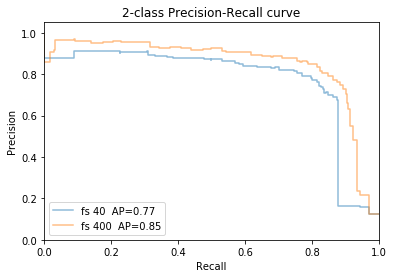

In [26]:
plot_pr_mat(rf)

In [90]:
print("accuracy_score: ",accuracy_score(Y_test,y_pred))
print("average precision: ",average_precision_score(Y_test,y_score))

print("balanced_accuracy_score: ",balanced_accuracy_score(Y_test,y_pred))
print("ROC AUC: ",roc_auc_score(Y_test,y_score))
print()
print(classification_report(Y_test,y_pred))

dfh.print_cm(Y_test, y_pred)

accuracy_score:  0.9478889311525295
average precision:  0.7747870484534496
balanced_accuracy_score:  0.8478092059170621
ROC AUC:  0.9139392736601231

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2303
           1       0.84      0.71      0.77       326

    accuracy                           0.95      2629
   macro avg       0.90      0.85      0.87      2629
weighted avg       0.95      0.95      0.95      2629

Confusion Matrix
C true,predicted

[[2259   44]
 [  93  233]]

true negatives  : true 0, predicted 0:  2259
false positives : true 0, predicted 1:  44
false negatives : true 1, predicted 0:  93
true positives  : true 1, predicted 1:  233


In [30]:
!jupyter nbconvert --to script rebal_bow.ipynb

[NbConvertApp] Converting notebook rebal_bow.ipynb to script
[NbConvertApp] Writing 15314 bytes to rebal_bow.py


In [87]:
words=np.array(bow_bal.get_feature_names()) 
display( (words[clf.steps[0][1].get_support()]) )

array(['can', 'carrefour', 'cloth', 'die', 'distribut', 'eat', 'food',
       'help', 'hunger', 'hungri', 'meal', 'medicin', 'need', 'nonperish',
       'ration', 'rice', 'starv', 'suppli', 'tent', 'water'], dtype='<U15')